# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 21.09.2020

Мягкий дедлайн: 02:59MSK 05.10.2020

Жесткий дедлайн: 23:59MSK 08.10.2020

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [60]:
!pip install folium

In [61]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

In [63]:
## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [64]:
df=pd.read_csv('train.csv')
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [65]:
df=df.drop(columns='dropoff_datetime')

In [66]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

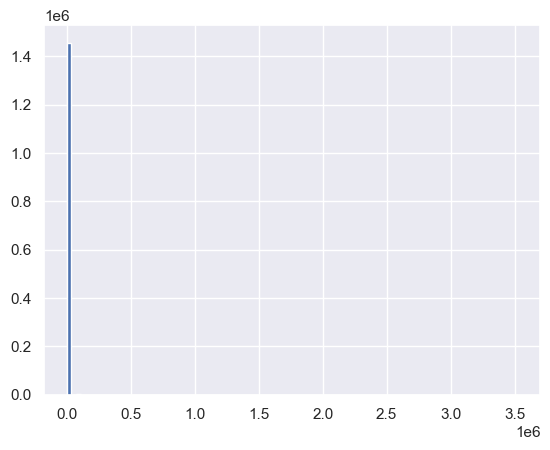

In [67]:
plt.hist(df['trip_duration'],bins=100)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

<font color='green'>Это говорит о том, что данные слишком разнородные, в trip_duration есть огромное кол-во объектов с маленькими значения: единица и меньше, так и с большими значениями больше несколько десятков тысяч. Диаграмма нам вывела только столбец только с маленькими значениями около нуля, так как для вывода всех столбцов места не хватит.</font>

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

<font color='green'>Метрика RMSLE выбирается, чтобы угадать неточный ответ, а размерность: тысячи, миллионы, десятки и тд.</font>

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

<font color='green'>Оптимизируя RMSLE нам важно, чтобы логарифмы разности стремились к нулю, для этого нужно чтобы разница между y и a тоже стремилась к нулю, если y и a стремятся к нулю, то это означает, что мы оптимизируем MSE.</font>

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [68]:
df=df.drop(columns='id')

In [69]:
from sklearn.model_selection import train_test_split

y=df['trip_duration']
X=df.drop(columns='trip_duration')
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)

In [70]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


best_constant=y_train.mean()

print("Test RMSE with best constant = %.4f" % mean_squared_error(y_test, best_constant * np.ones(y_test.shape),
                                                                 squared=False))
print("Train RMSE with best constant = %.4f" % mean_squared_error(y_train, best_constant * np.ones(y_train.shape),
                                                                  squared=False))

Test RMSE with best constant = 3177.5443
Train RMSE with best constant = 5904.1942


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

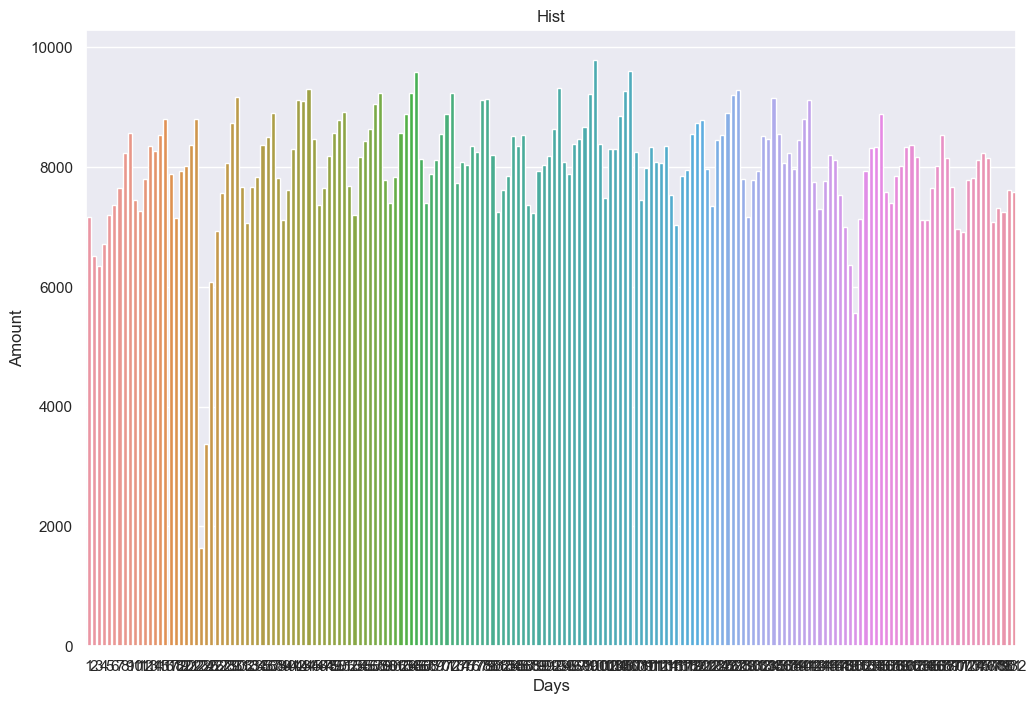

In [71]:
df['day_of_the_year']=df['pickup_datetime'].dt.dayofyear
plt.figure(figsize=(12,8))
sns.countplot(x='day_of_the_year',data=df)
plt.title('Hist')
plt.xlabel('Days')
plt.ylabel('Amount')
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

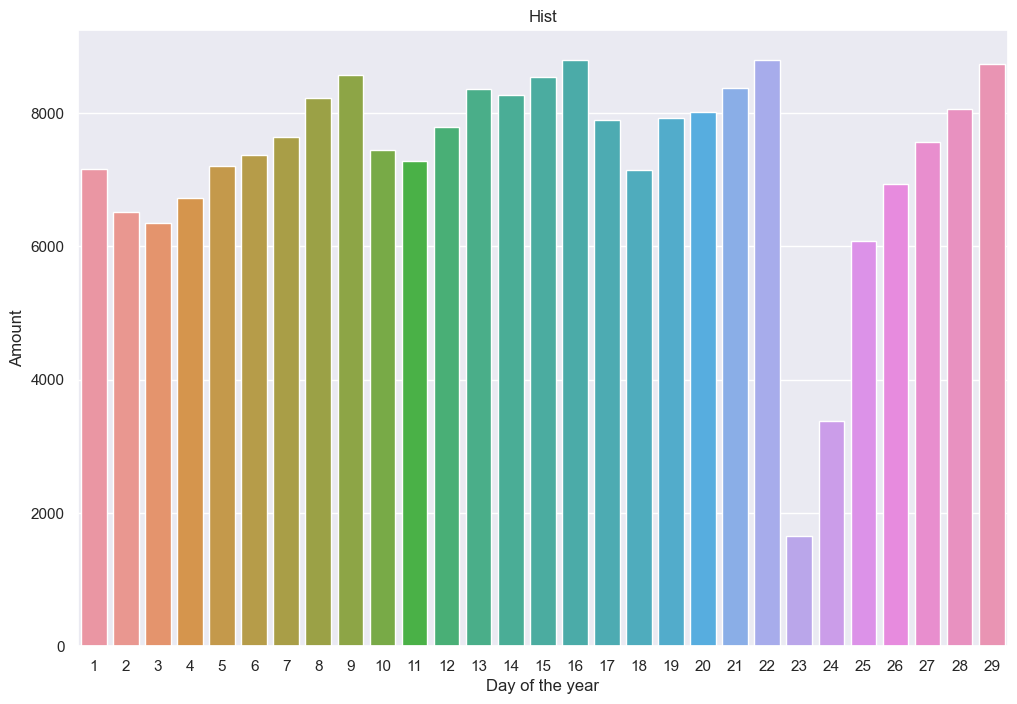

In [72]:
df['day_of_the_year']=df['pickup_datetime'].dt.dayofyear
plt.figure(figsize=(12,8))
sns.countplot(x='day_of_the_year',data=df[df['day_of_the_year']<30])
plt.title('Hist')
plt.xlabel('Day of the year')
plt.ylabel('Amount')
plt.show()

In [73]:
anomal=df['day_of_the_year'].value_counts()
Anomal_days=anomal[anomal<4000].index
Anomal_days

Index([24, 23], dtype='int32', name='day_of_the_year')

<font color='green'>23 и 24 января в Нью-Йорке из-за снежной бури запретили автомобильное движение, поэтому эти две точки выделяются аномальными датами кол-ва поездок</font>

In [74]:
df['hour']=df['pickup_datetime'].dt.hour
df['month']=df['pickup_datetime'].dt.month
df['week']=df['pickup_datetime'].dt.day_name()

/var/folders/v5/fp4628yd2w79w0w7m97sx0_w0000gn/T/ipykernel_30355/2881926169.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=weeks,x='week',y='number_of_trips',kind='line', palette='deep')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


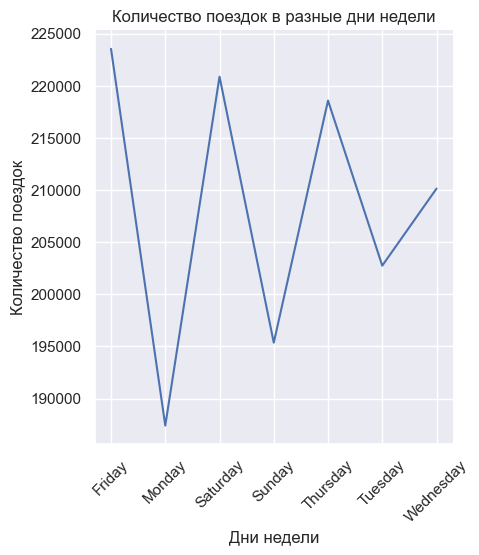

In [75]:
weeks=df.groupby(['week'])['vendor_id'].count().reset_index()
weeks['number_of_trips']=weeks['vendor_id']
weeks=weeks.drop(columns='vendor_id')


sns.relplot(data=weeks,x='week',y='number_of_trips',kind='line', palette='deep')
plt.title('Количество поездок в разные дни недели')
plt.xlabel('Дни недели')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45) 
# plt.xticks(range(0, 24))
plt.show()


/var/folders/v5/fp4628yd2w79w0w7m97sx0_w0000gn/T/ipykernel_30355/2720066970.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=hours,x='hour',y='number_of_trips',kind='line', palette='deep')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


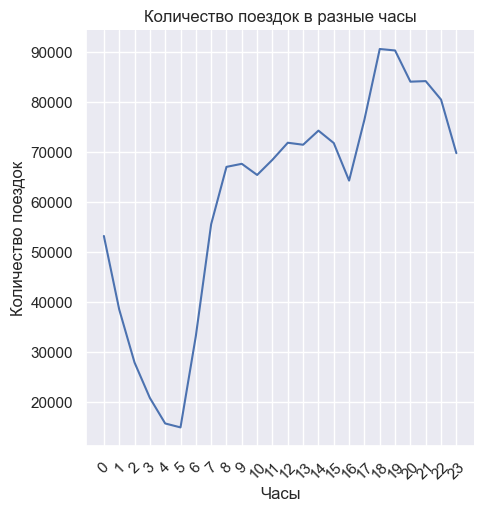

In [76]:
hours=df.groupby(['hour'])['vendor_id'].count().reset_index()
hours['number_of_trips']=hours['vendor_id']
hours=hours.drop(columns='vendor_id')


sns.relplot(data=hours,x='hour',y='number_of_trips',kind='line', palette='deep')
plt.title('Количество поездок в разные часы')
plt.xlabel('Часы')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45) 
plt.xticks(range(0, 24))
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


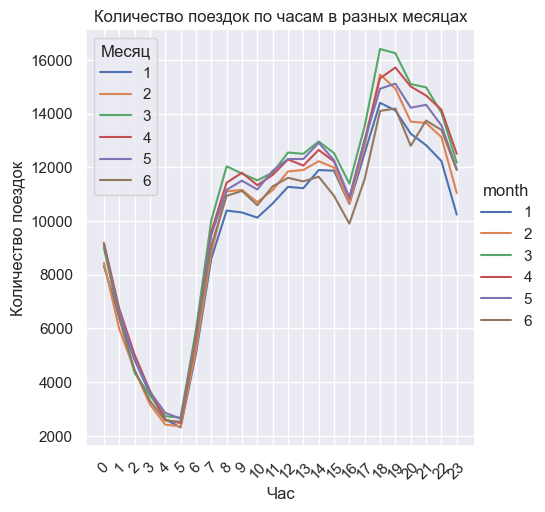

In [77]:
hour_trips=df.groupby(['hour', 'month'])['vendor_id'].count().reset_index()
hour_trips['number_of_trips']=hour_trips['vendor_id']
hour_trips=hour_trips.drop(columns='vendor_id')

sns.relplot(data=hour_trips,x='hour',y='number_of_trips',hue='month',kind='line', palette='deep')
plt.title('Количество поездок по часам в разных месяцах')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.xticks(range(0, 24))
plt.xticks(rotation=45)
plt.legend(title='Месяц')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


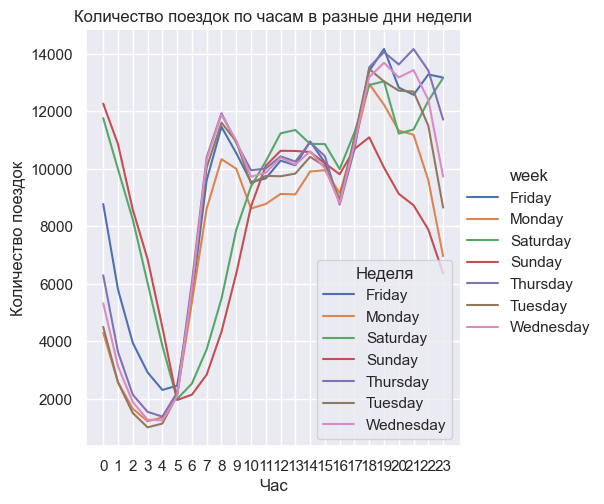

In [78]:
week_trips=df.groupby(['hour','week'])['vendor_id'].count().reset_index()
week_trips['number_of_trips']=week_trips['vendor_id']
week_trips=week_trips.drop(columns='vendor_id')

sns.relplot(data=week_trips,x='hour',y='number_of_trips',hue='week',kind='line',palette='deep')
plt.title('Количество поездок по часам в разные дни недели')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.xticks(range(0, 24))
plt.legend(title='Неделя')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

<font color='green'>Из графиков видно, что кол-во поездок начинает резко возрастать с 5 утра до 9 утра, и с 16 часов до 19 часов, далее идет спад. Пик наблюдается от 18 до 19 часов</font>

<font color='green'>Самый популярный месяц-март и апрель, день недели- пт,ср,чт. Непопулярный месяц - январь и июнь, день недели- вскр</font>

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [79]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'day_of_the_year', 'hour',
       'month', 'week'],
      dtype='object')

In [80]:
y=df['trip_duration']
X=df.drop(columns='trip_duration')
X['log_trip_duration']=np.log(y+1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)

/var/folders/v5/fp4628yd2w79w0w7m97sx0_w0000gn/T/ipykernel_30355/679674061.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=log_weeks_trips,x='week',y='log_trip_duration',kind='line',palette='deep')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

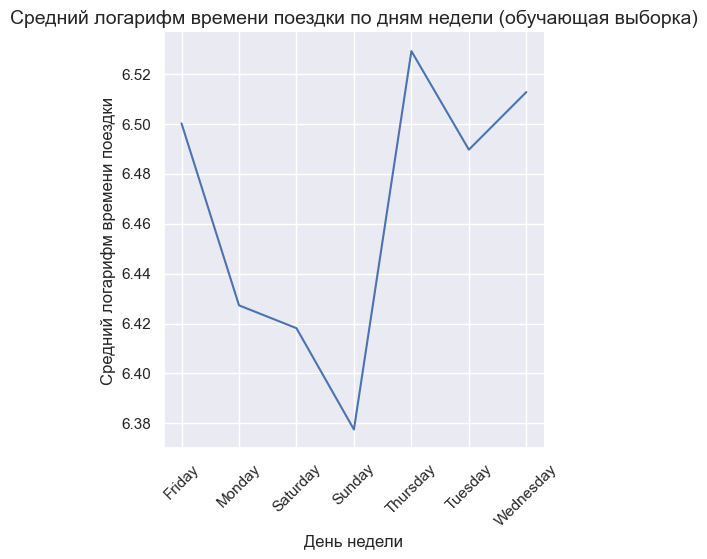

In [81]:
log_weeks_trips=X_train.groupby(['week'])['log_trip_duration'].mean().reset_index()


plt.figure(figsize=(10,6))
sns.relplot(data=log_weeks_trips,x='week',y='log_trip_duration',kind='line',palette='deep')
plt.title('Средний логарифм времени поездки по дням недели (обучающая выборка)', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Средний логарифм времени поездки', fontsize=12)
plt.xticks(rotation=45)
plt.show()

/var/folders/v5/fp4628yd2w79w0w7m97sx0_w0000gn/T/ipykernel_30355/1815334808.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=log_hour_trips,x='hour',y='log_trip_duration',kind='line',palette='deep')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

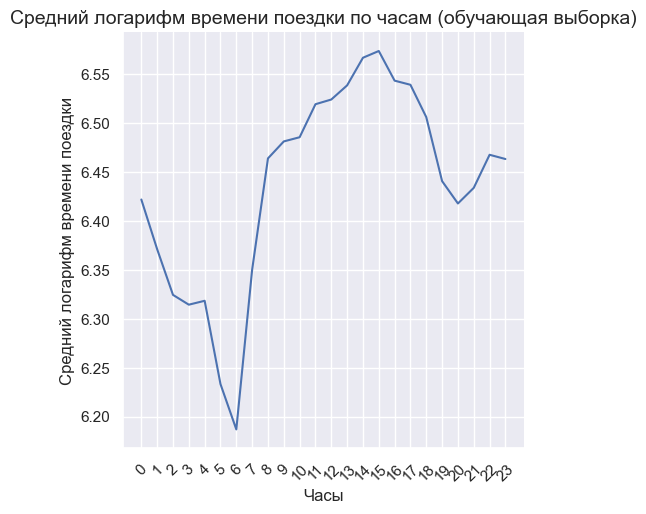

In [82]:
log_hour_trips=X_train.groupby(['hour'])['log_trip_duration'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.relplot(data=log_hour_trips,x='hour',y='log_trip_duration',kind='line',palette='deep')
plt.title('Средний логарифм времени поездки по часам (обучающая выборка)', fontsize=14)
plt.xlabel('Часы', fontsize=12)
plt.ylabel('Средний логарифм времени поездки', fontsize=12)
plt.xticks(rotation=45)
plt.xticks(range(0, 24))
plt.show()

/var/folders/v5/fp4628yd2w79w0w7m97sx0_w0000gn/T/ipykernel_30355/3336095012.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=log_days_trips,x='day_of_the_year',y='log_trip_duration',kind='line',palette='deep')
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x700 with 0 Axes>

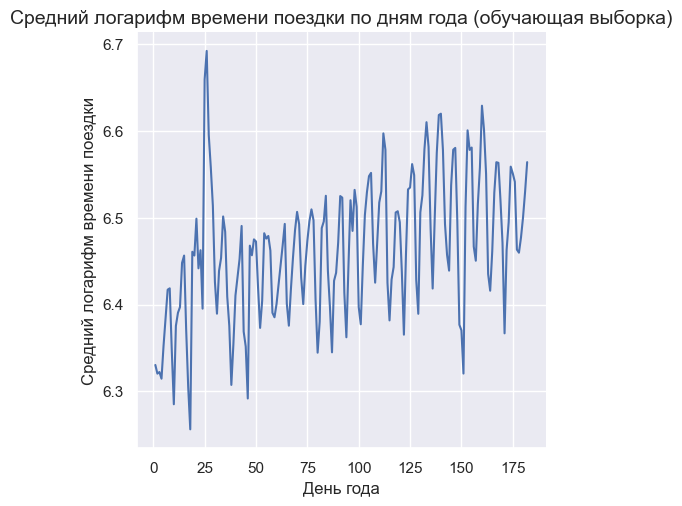

In [83]:
log_days_trips=X_train.groupby(['day_of_the_year'])['log_trip_duration'].mean().reset_index()

plt.figure(figsize=(15,7))
sns.relplot(data=log_days_trips,x='day_of_the_year',y='log_trip_duration',kind='line',palette='deep')
plt.title('Средний логарифм времени поездки по дням года (обучающая выборка)', fontsize=14)
plt.xlabel('День года', fontsize=12)
plt.ylabel('Средний логарифм времени поездки', fontsize=12)
# plt.xticks(rotation=45)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

<font color='green'>Да похожи, потому что есть некая зависимость между таргетом и кол-вом поездок от дня недели и часах. Например, в час пики увеличивается как и кол-во поездок, так и время поездки, так как всем нужно ехать на работу, но в тоже время пробки. Также на обоих графиках видно, что со ср по пт самые интенсивные дни, увеличивается кол-во поездок и среднее время поездки. Средний логарифм времени поездки в аномальные дни был самым маленьким, потому что было отменено автомобильное движение по городу. Да, наблюдается восходящий, но при этом волатильный тренд. </font>

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [84]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'day_of_the_year', 'hour',
       'month', 'week'],
      dtype='object')

In [85]:
def anomal_days(row):
    if row == 23:
        return pd.Series([1, 0])  # Возвращаем как pd.Series, чтобы соответствовать двум столбцам
    elif row == 24:
        return pd.Series([0, 1])
    else:
        return pd.Series([0, 0])

In [86]:
df[['23_anomal', '24_anomal']] = df.apply(lambda row: anomal_days(row['day_of_the_year']), axis=1)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

<font color='green'>Признаки значения которых строки- категориальные, числа- численные. Потому что модель не модет обучаться на категориальных признаках без One hot encoding</font>

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [87]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'day_of_the_year', 'hour',
       'month', 'week', '23_anomal', '24_anomal'],
      dtype='object')

In [88]:
y=df['trip_duration']
X=df.drop(columns='trip_duration')
X=X[['day_of_the_year','hour','month','week','23_anomal','24_anomal']]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)

In [89]:
numeric=X_train.select_dtypes([np.number]).columns
categorical=list(X_train.dtypes[X_train.dtypes=='object'].index)

In [90]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

column_transformer=ColumnTransformer([
    ('ohe',OneHotEncoder(handle_unknown="ignore"),categorical), #игнорируем новые значения на тестовой выборке если она встретятся 
    ('scaling',StandardScaler(),numeric)
])

pipeline=Pipeline(steps=[
    ('ohe_and_scaling',column_transformer),
    ('regression',Ridge())    
])

model=pipeline.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 3177.0655


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [91]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [92]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [93]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "red")

**Вопрос**: Какие две точки выделяются на карте?

<font color='green'>Выделяются точка  в аэропорту Kennedy и Laguardia, так как они отдалены от концентраций точек</font>

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [94]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


In [95]:
df['distance_haversine']=df.iloc[:,:].apply(lambda x: 
                            haversine_array(x['pickup_latitude'], 
                                            x['pickup_longitude'], 
                                            x['dropoff_latitude'], 
                                            x['dropoff_longitude']),
                            axis=1)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [96]:
df['log_distance_haversine']=np.log(df['distance_haversine']+1)
df['log_trip_duration']=np.log(df['trip_duration']+1)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

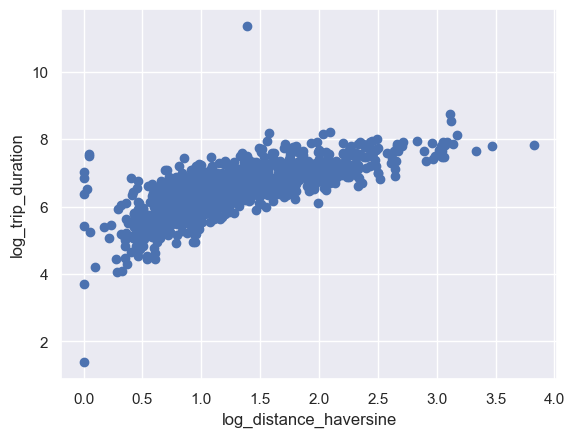

In [97]:
plt.scatter(df['log_distance_haversine'][:1000],df['log_trip_duration'][:1000],marker='o')
plt.xlabel('log_distance_haversine')
plt.ylabel('log_trip_duration')
plt.show()

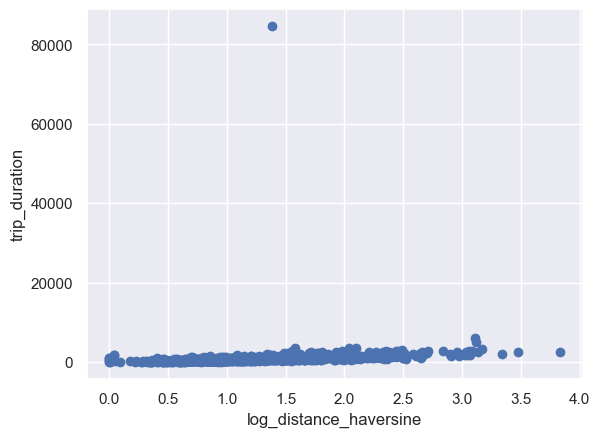

In [98]:
plt.scatter(df['log_distance_haversine'][:1000],df['trip_duration'][:1000],marker='o')
plt.xlabel('log_distance_haversine')
plt.ylabel('trip_duration')
plt.show()

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [99]:
def av_speeds(dist,trip):
    middle=dist/trip
    return pd.Series(middle)

In [100]:
# df['av_speed']=df.apply(lambda row: av_speed(row['distance_haversine'],row['trip_duration']),axis=1) #не самый быстрый способ
df.loc[:,'av_speed']=av_speeds(df['distance_haversine'].values, df['trip_duration'].values)

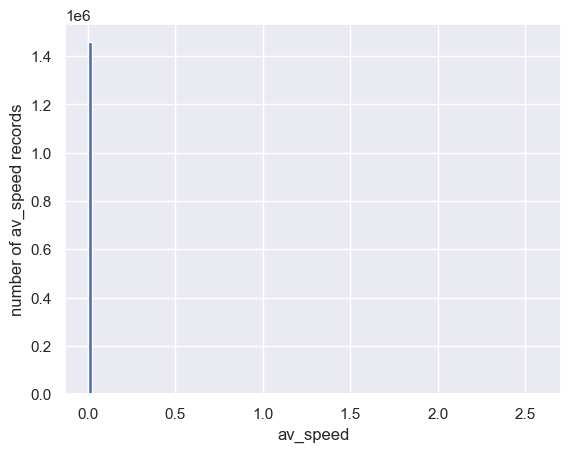

In [101]:
plt.hist(df['av_speed'].values,bins=100)
plt.xlabel('av_speed')
plt.ylabel('number of av_speed records')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

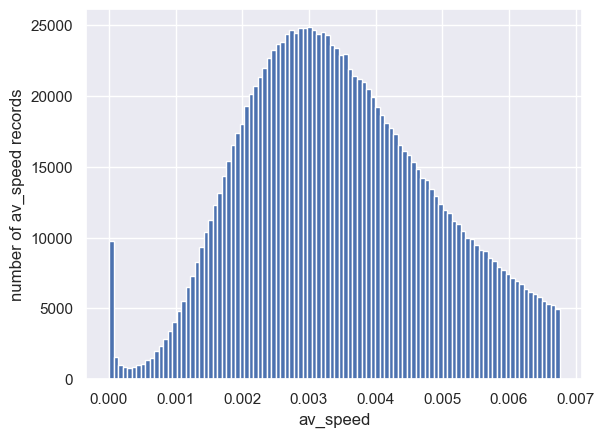

In [102]:
quant=np.quantile(df['av_speed'],0.9)

new_val=df['av_speed'][df['av_speed']<quant]
plt.hist(new_val.values,bins=100)
plt.xlabel('av_speed')
plt.ylabel('number of av_speed records')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [103]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'day_of_the_year', 'hour',
       'month', 'week', '23_anomal', '24_anomal', 'distance_haversine',
       'log_distance_haversine', 'log_trip_duration', 'av_speed'],
      dtype='object')

In [104]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday

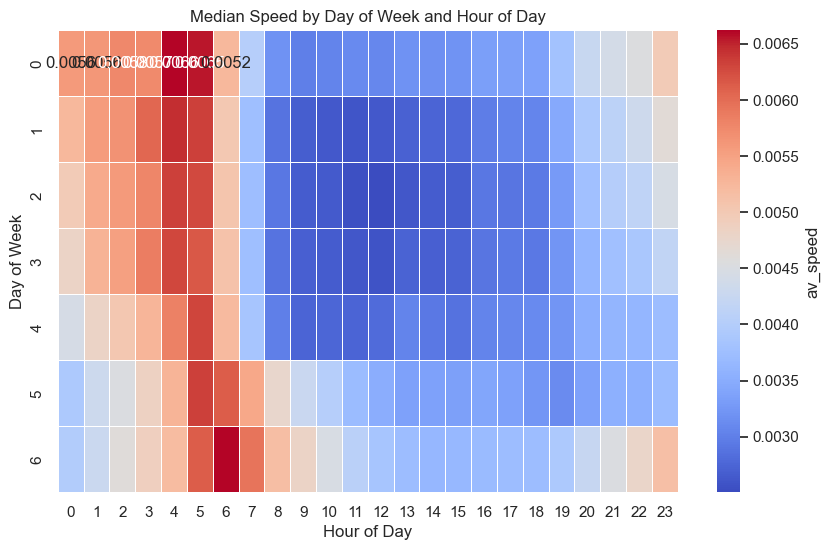

In [105]:
grouped =df.groupby(['day_of_week','hour'])['av_speed'].median().reset_index()
# Преобразование в формат матрицы для тепловой карты
heatmap_data = grouped.pivot(index='day_of_week', columns='hour', values='av_speed')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5, cbar_kws={'label': 'av_speed'})
plt.title('Median Speed by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

<font color='green'>Потому что скорость можно получить из таргета путем деления расстояния на время поезддки, а время поездки - это таргет, если мы будет использовать скорость в обучении, то это означает, что мы используем таргет в обучении, модель из-за этого непрезентативна</font>

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

<font color='green'>Средняя скорость минимальна с 7 до 19 часов с пн по пт - т.е. в рабочие дни и рабочее время. </font>

In [106]:
def traffic_jam(row):
    traffic_hours=list(range(7,20))
    traffic_days=list(range(0,5))
    if row['hour'] in traffic_hours and  row['day_of_week'] in traffic_days:
             return pd.Series(1)
    else:
        return pd.Series(0)

In [107]:
df['traffic_jam']=df.apply(lambda row:traffic_jam(row),axis=1)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [108]:
df["is_dropoff_in_kennedy"] = 0
df["is_dropoff_in_laguardia"] = 0
df["is_pickup_in_kennedy"] = 0
df["is_pickup_in_laguardia"] = 0

laguardia_longitude = -73.873173
laguardia_latitude = 40.772027

kennedy_longitude = -73.781970
kennedy_latitude = 40.643904

In [109]:
df.loc[haversine_array(df["dropoff_latitude"], df["dropoff_longitude"],
                       kennedy_latitude, kennedy_longitude)<1.5,'is_dropoff_in_kennedy']=1  # 1.5 km radius
df.loc[haversine_array(df["dropoff_latitude"], df["dropoff_longitude"],
                       laguardia_latitude, laguardia_longitude)<1.5,'is_dropoff_in_laguardia']=1 # 1.5 km radius
df.loc[haversine_array(df["pickup_latitude"], df["pickup_longitude"],
                       kennedy_latitude, kennedy_longitude)<1.5,'is_pickup_in_kennedy']=1 # 1.5 km radius
df.loc[haversine_array(df["pickup_latitude"], df["pickup_longitude"],
                       laguardia_latitude, laguardia_longitude)<1.5,'is_pickup_in_laguardia']=1 # 1.5 km radius

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

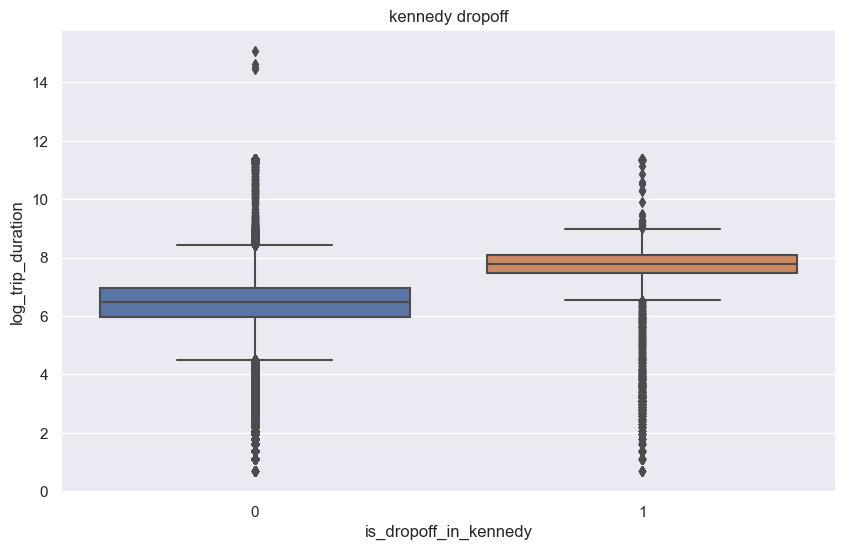

In [110]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_dropoff_in_kennedy',y='log_trip_duration',data=df)
plt.title('kennedy dropoff')

plt.show()#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

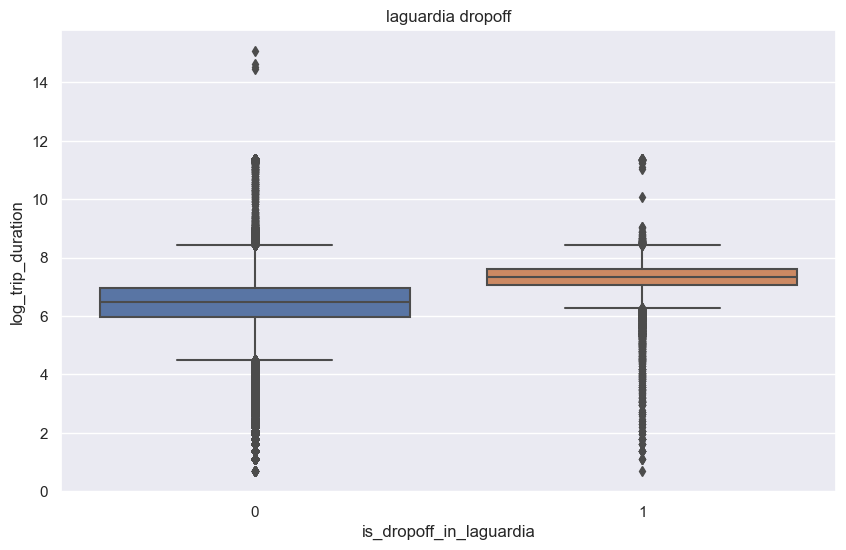

In [111]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_dropoff_in_laguardia',y='log_trip_duration',data=df)
plt.title('laguardia dropoff')

plt.show()

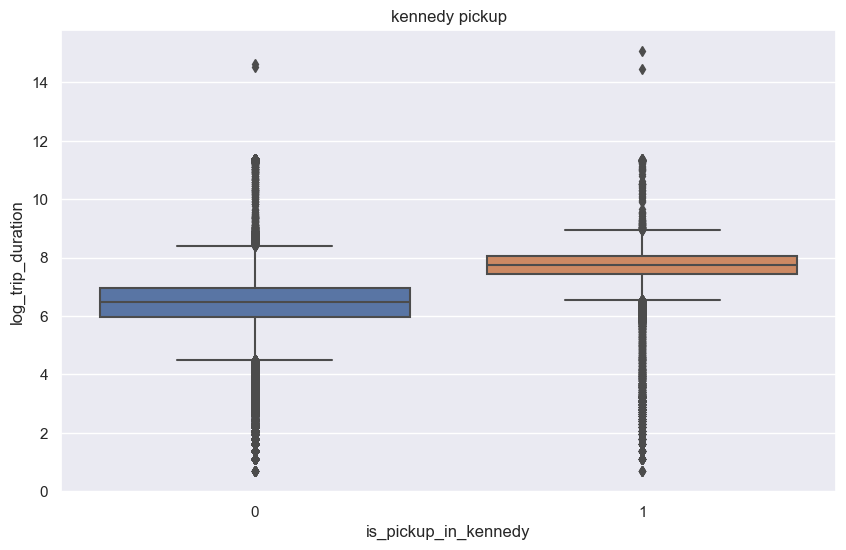

In [112]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_pickup_in_kennedy',y='log_trip_duration',data=df)
plt.title('kennedy pickup')
plt.show()

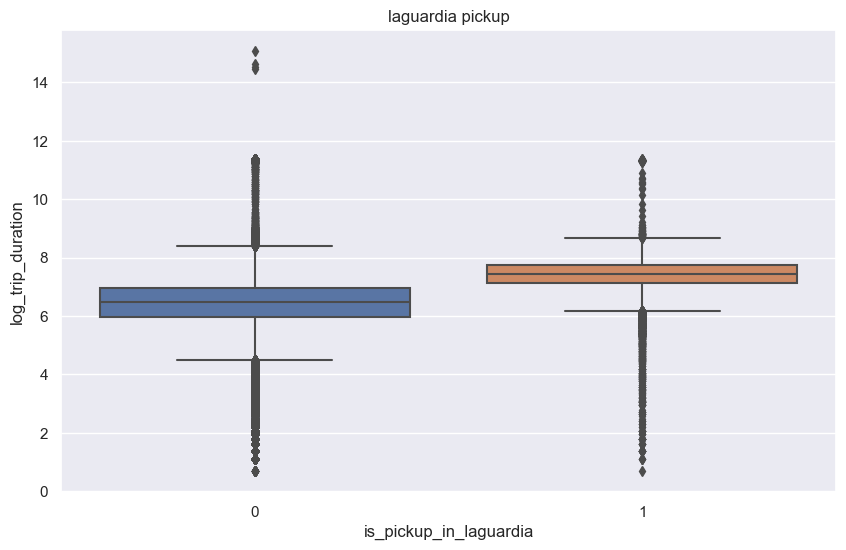

In [113]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_pickup_in_laguardia',y='log_trip_duration',data=df)
plt.title('laguardia pickup')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<font color='green'>Распределения получились различными: медиана 1 выше чем 0 в двух точках аэропортов высадки и посадки. Это свидетельствует о том, что 
среднее время поездки у 1 выше, также медиана у значений = 1  в двух точках приближена к 8, в то время как у значений = 0 приближена к 6                                                                       </font>

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [114]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class MapGridTransformer(BaseEstimator, TransformerMixin):
#     #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

SyntaxError: incomplete input (4038650922.py, line 4)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [115]:
# y=df['trip_duration']
# X=df.drop(columns=['trip_duration','id','vendor_id','passenger_count','store_and_fwd_flag','av_speed','log_trip_duration',
#                   'distance_haversine'])
categorical = ["week", "hour", "23_anomal", "24_anomal","month", "day_of_the_year", 
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "traffic_jam"]
numeric = ["log_distance_haversine"]

X_train, X_test, y_train, y_test = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.3,random_state=10)

In [116]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4863


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

<font color='green'>vendor_id - это номер поставщика такси, предположим могут быстрые и медленные операторы. Passenger_count - кол-во пассажиров,если такси слишком загруженное, то это может создавать помехи для водителя, когда колв-во людей в салоне переполнено. Store_and_fwd_flag- отражает, как данные передавались на сервер: либо с задержкой (при временном сохранении), либо в режиме реального времени, задержка данных может указывать на неточную переданную информацию. </font>

In [117]:
df['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

In [118]:
df['passenger_count'].value_counts()

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

In [119]:
df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

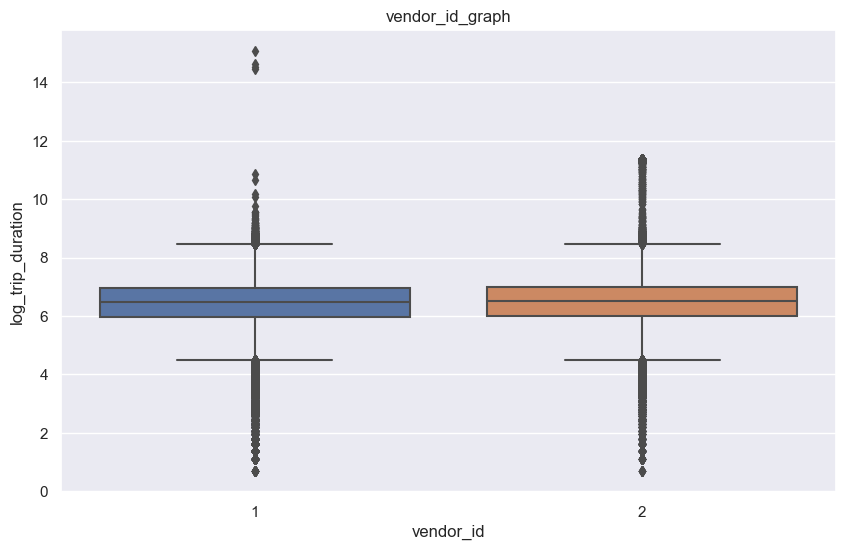

In [120]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df,x='vendor_id',y='log_trip_duration')
plt.title('vendor_id_graph')
plt.show()

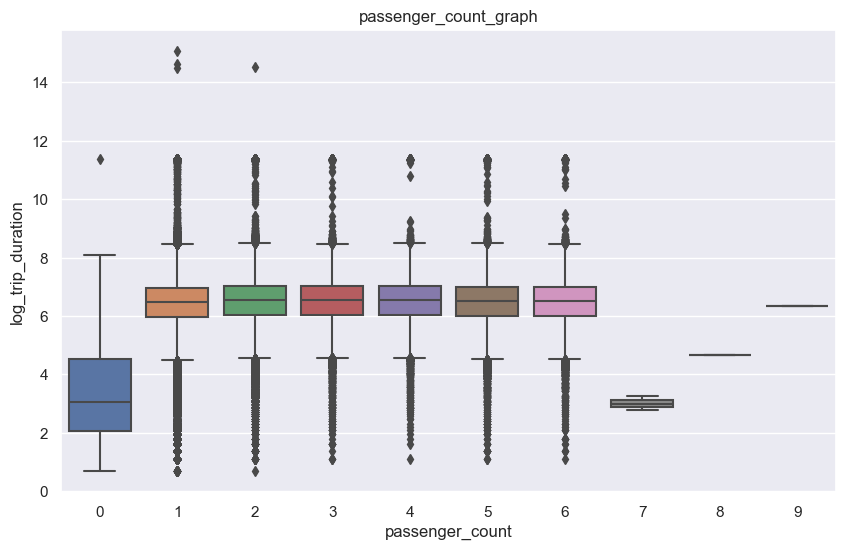

In [121]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df,x='passenger_count',y='log_trip_duration')
plt.title('passenger_count_graph')
plt.show()

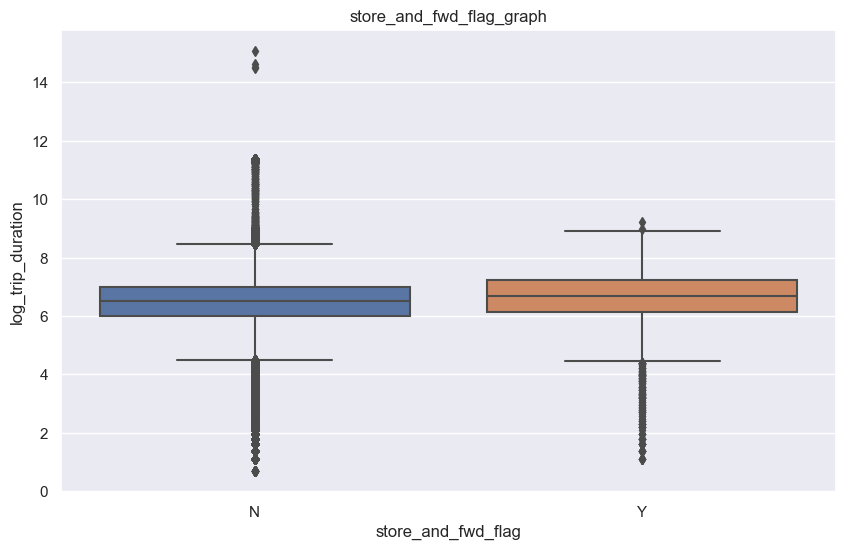

In [122]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df,x='store_and_fwd_flag',y='log_trip_duration')
plt.title('store_and_fwd_flag_graph')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [123]:
df['vendor_id']=df['vendor_id'].map({'1': 0, '2':1})
df['store_and_fwd_flag']=df['vendor_id'].map({'N': 0, 'Y':1})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

<font color='green'>Скорее всего нет, так как распредления получились практическими одинаковыми, существенных различий разных значений какого-либо признака нет. </font>

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [124]:

categorical = ["week", "hour", "23_anomal", "24_anomal","month", "day_of_the_year", 
               "is_pickup_in_laguardia", "is_dropoff_in_laguardia", "is_pickup_in_kennedy", "is_dropoff_in_kennedy",
               "traffic_jam","store_and_fwd_flag","vendor_id","passenger_count"]
numeric = ["log_distance_haversine"]

X_train, X_test, y_train, y_test = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.3,random_state=10)

In [125]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4861


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

<font color='green'>Результат практически не улучшился, поэтому можно викинуть эти признаки. </font>

In [126]:
df=df.drop(columns=['vendor_id','store_and_fwd_flag','passenger_count'])

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

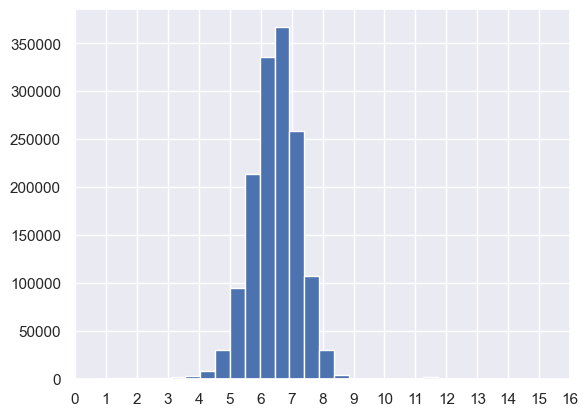

In [127]:
plt.hist(df['log_trip_duration'],bins=30)
plt.xticks(range(0, 17))
plt.show()

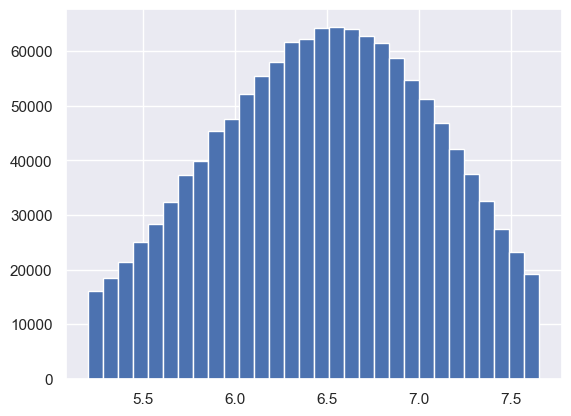

In [128]:
quant_9=np.quantile(df['log_trip_duration'],0.95)
quant_1=np.quantile(df['log_trip_duration'],0.05)
log_trip_duration_quantiled=df['log_trip_duration'][(df['log_trip_duration'] < quant_9) & (df['log_trip_duration'] > quant_1)]
plt.hist(log_trip_duration_quantiled,bins=30)
plt.show()

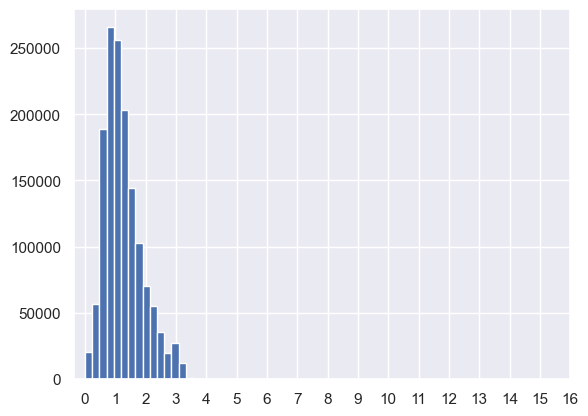

In [129]:
plt.hist(df['log_distance_haversine'],bins=30)
plt.xticks(range(0, 17))
plt.show()

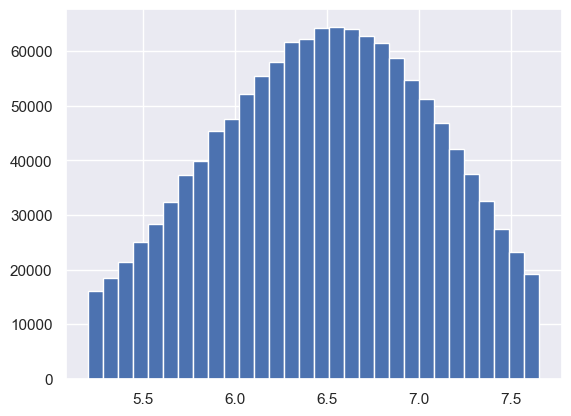

In [130]:
quant_9=np.quantile(df['log_distance_haversine'],0.95)
quant_1=np.quantile(df['log_distance_haversine'],0.05)
log_distance_haversine_quantiled=df['log_distance_haversine'][(df['log_distance_haversine'] < quant_9) & (df['log_distance_haversine'] > quant_1)]
plt.hist(log_trip_duration_quantiled,bins=30)
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

<font color='green'>Действительно редких категорий, которые можно будет объединить в одную категорию, не наблюдается. </font>

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [131]:
df.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'day_of_the_year', 'hour', 'month', 'week', '23_anomal', '24_anomal',
       'distance_haversine', 'log_distance_haversine', 'log_trip_duration',
       'av_speed', 'day_of_week', 'traffic_jam', 'is_dropoff_in_kennedy',
       'is_dropoff_in_laguardia', 'is_pickup_in_kennedy',
       'is_pickup_in_laguardia'],
      dtype='object')

In [132]:
categorical = ['day_of_the_year', 'hour', 'month', 'week', '23_anomal', '24_anomal',
       'traffic_jam', 'is_dropoff_in_kennedy',
       'is_dropoff_in_laguardia', 'is_pickup_in_kennedy',
       'is_pickup_in_laguardia']
numeric = ["log_distance_haversine"]

X_train, X_test, y_train, y_test = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.3,random_state=10)

In [133]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4863


<font color='green'>Мы не берем в оборот эти признаки ['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'], тк по графикам(ящик с усами) и карте можно понять, что у нас есть 2 глобальных  случая: точка в двух аэропортах и точка в области концентрации всех точек.Если точка находится в аэропортах, то медиана таргета ≈ 8, если нет, то медиана ≈ 6 Такие признаки как [is_dropoff_in_laguardia', 'is_pickup_in_kennedy','is_pickup_in_laguardia','is_dropoff_in_kennedy'] позволяют нам понять где  находится точка: в аэропортах или в области концентрации всех точек. Также при включении ['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'] кол-во признаков возрастает более млн, что вызывает переобучение. </font>

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [134]:
print("Size before OneHot:", X_train.shape[1])
print("Size after OneHot:", column_transformer.transform(X_train).shape[1])

Size before OneHot: 12
Size after OneHot: 234


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [135]:
from sklearn.linear_model import Lasso

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7943


<font color='green'>Лучше Ridge</font>

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

<font color='green'>Находим best alpha для Ridge</font>

In [136]:
X_train, X_val, y_train, y_val = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.2,random_state=42)

In [137]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)
])

# X_train_processed=pipeline.fit_transform(X_train)
X_val_processed=pipeline.fit_transform(X_val)

In [138]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
search_ridge=GridSearchCV(Ridge(),[{'alpha':alphas}],scoring='neg_root_mean_squared_error',cv=10)
search_ridge.fit(X_val_processed,y_val)

best_alpha_ridge=search_ridge.best_params_['alpha']
print("Best alpha ridge = %.4f" % best_alpha_ridge)

Best alpha ridge = 48.3293


In [139]:
X_train, X_test, y_train, y_test = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.3,random_state=10)

In [140]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline_ridge.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE with the best aplha - Ridge = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE with the best aplha - Ridge = 0.4863


<font color='green'>Сейчас тоже самое, но для Lasso</font>

In [141]:
X_train, X_val, y_train, y_val = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.2,random_state=42)

In [142]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)
])

# X_train_processed=pipeline.fit_transform(X_train)
X_val_processed=pipeline.fit_transform(X_val)

In [143]:
alphas = np.logspace(-2, 3, 20)
search_lasso=GridSearchCV(Lasso(),[{'alpha':alphas}],scoring='neg_root_mean_squared_error',cv=10)
search_lasso.fit(X_val_processed,y_val)

best_alpha_lasso=search_lasso.best_params_['alpha']
print("Best alpha lasso = %.4f" % best_alpha_lasso)

Best alpha lasso = 0.0100


In [144]:
X_train, X_test, y_train, y_test = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.3,random_state=10)

In [145]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

model = pipeline_lasso.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE with the best aplha - Lasso = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE with the best aplha - Lasso = 0.5083


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [146]:
ridge_zeros = np.sum(pipeline_ridge.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(pipeline_lasso.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 230


In [147]:
al_wg=list()
for alp in np.logspace(-2, 0.5, 30):
    pipeline_сheck_weight = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alp))
])
    model = pipeline_lasso.fit(X_train, y_train)
    lasso_zeros = np.sum(pipeline_lasso.steps[-1][-1].coef_ == 0)
    al_wg.append([alp,lasso_zeros])    

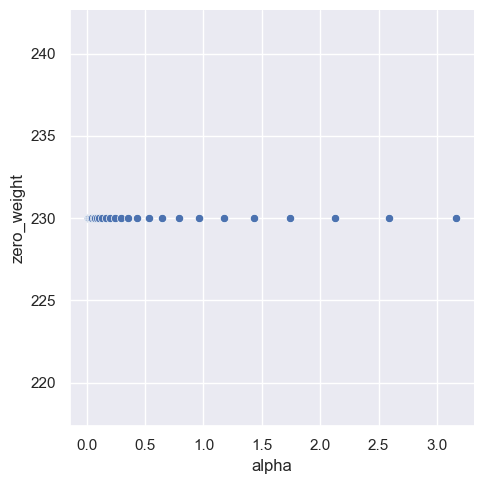

In [148]:
zero_weights=pd.DataFrame(al_wg, columns=['alpha','zero_weight'])
sns.relplot(data=zero_weights,x='alpha',y='zero_weight')
plt.show()

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

<font color='green'>Манхэттенское расстояние особенно полезно в задачах, где перемещения ограничены ортогональными направлениями, например, как в случае городских сетей дорог, когда объекты (такси) движутся по строго определённым улицам. В контексте задачи New York City Taxi Trip Duration:

<font color='green'>•	Отражает реальные маршруты: Такси в Нью-Йорке передвигаются по сетке улиц, поэтому использование манхэттенского расстояния вместо евклидова более точно описывает реальную длину маршрута.</font>

 <font color='green'> •	Быстрота расчётов: Манхэттенское расстояние вычисляется быстрее, чем евклидово, так как не требует вычисления квадратных корней. Это может ускорить расчёты при обработке больших объемов данных.</font>

<font color='green'>Таким образом, манхэттенское расстояние лучше соответствует реальной дорожной ситуации в Нью-Йорке и может улучшить точность модели, предсказывающей продолжительность поездки.</font>



<font color='black'>Сейчас посчитаем манхэттенское расстояние и выявим, какая лучшая модель: обучившаяся на хаверсин или манхэттенском расстоянии. </font>

In [162]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [150]:
df.loc[:,'manhattan']=dummy_manhattan_distance(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, train['dropoff_longitude'].values)
df['log_manhattan']=np.log(df['manhattan']+1)

In [155]:
categorical = ['day_of_the_year', 'hour', 'month', 'week', '23_anomal', '24_anomal',
       'traffic_jam', 'is_dropoff_in_kennedy',
       'is_dropoff_in_laguardia', 'is_pickup_in_kennedy',
       'is_pickup_in_laguardia']
numeric = ["log_manhattan"]

In [156]:
X_train, X_val, y_train, y_val = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.2,random_state=42)

In [157]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer)
])

X_val_processed=pipeline.fit_transform(X_val)

In [158]:
alphas = np.logspace(-2, 3, 20)
search_ridge=GridSearchCV(Ridge(),[{'alpha':alphas}],scoring='neg_root_mean_squared_error',cv=10)
search_ridge.fit(X_val_processed,y_val)

best_alpha_ridge=search_ridge.best_params_['alpha']
print("Best alpha ridge = %.4f" % best_alpha_ridge)

Best alpha ridge = 48.3293


In [159]:
X_train, X_test, y_train, y_test = train_test_split(df[categorical + numeric], df["log_trip_duration"], test_size=0.3,random_state=10)

In [161]:
pipeline_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline_ridge.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE with the best aplha - Ridge = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE with the best aplha - Ridge = 0.4942


<font color='green'>В итоге модель с  хаверсин расстоянием  получилась лучше </font>